# Matrix Multiplication Speed Benchmark

Comparing performance of:
1. Standard NumPy matrix multiplication
2. Standard PyTorch matrix multiplication
3. NumPy LMUL matrix multiplication
4. NumPy LMUL scalar (element-wise)
5. PyTorch LMUL matrix multiplication
6. PyTorch LMUL scalar (element-wise)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

os.chdir(Path.cwd().parent)

from rtl.numpy_lmul import lmul_numpy_matmul, lmul_numpy_float
from utils.floats import float_to_bf16_array, float_to_bf16_tensor

try:
    import torch
    from rtl.pytorch_lmul import lmul_torch_matmul, lmul_torch_float
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False


In [2]:
matrix_sizes = np.array([10, 20, 50, 100, 200])

np_times = []
pytorch_standard_times = []
numpy_lmul_times = []
numpy_lmul_scalar_times = []
pytorch_lmul_times = []
pytorch_lmul_scalar_times = []

def lmul_numpy_matmul_scalar(a_bf16, b_bf16):
    """Matrix multiplication using scalar/element-wise LMUL"""
    m, n = a_bf16.shape
    n_b, p = b_bf16.shape
    result = np.zeros((m, p), dtype=np.float32)
    
    for i in range(m):
        for j in range(p):
            # Compute element-wise LMUL products
            products = lmul_numpy_float(a_bf16[i, :], b_bf16[:, j])
            result[i, j] = np.sum(products)
    
    return result

def lmul_torch_matmul_scalar(a_bf16, b_bf16):
    """Matrix multiplication using scalar/element-wise LMUL"""
    m, n = a_bf16.shape
    n_b, p = b_bf16.shape
    result = torch.zeros((m, p), dtype=torch.float32, device=a_bf16.device)
    
    for i in range(m):
        for j in range(p):
            # Compute element-wise LMUL products
            products = lmul_torch_float(a_bf16[i, :], b_bf16[:, j])
            result[i, j] = products.sum()
    
    return result


In [3]:
for size in matrix_sizes:
    np.random.seed(42)
    a = np.random.uniform(-10, 10, (size, size)).astype(np.float32)
    b = np.random.uniform(-10, 10, (size, size)).astype(np.float32)
    
    start = time.time()
    np_result = a @ b
    np_times.append(time.time() - start)
    
    if TORCH_AVAILABLE:
        a_torch = torch.from_numpy(a)
        b_torch = torch.from_numpy(b)
        _ = a_torch @ b_torch
        start = time.time()
        pytorch_standard_result = a_torch @ b_torch
        torch.synchronize() if torch.cuda.is_available() else None
        pytorch_standard_times.append(time.time() - start)
    else:
        pytorch_standard_times.append(None)
    
    # Convert to BF16 before timing LMUL operations
    a_bf16 = float_to_bf16_array(a)
    b_bf16 = float_to_bf16_array(b)
    
    start = time.time()
    numpy_lmul_result = lmul_numpy_matmul(a_bf16, b_bf16)
    numpy_lmul_times.append(time.time() - start)
    
    start = time.time()
    numpy_lmul_scalar_result = lmul_numpy_matmul_scalar(a_bf16, b_bf16)
    numpy_lmul_scalar_times.append(time.time() - start)
    
    if TORCH_AVAILABLE:
        a_torch_bf16 = float_to_bf16_tensor(a_torch)
        b_torch_bf16 = float_to_bf16_tensor(b_torch)
        
        _ = lmul_torch_matmul(a_torch_bf16, b_torch_bf16)
        start = time.time()
        pytorch_lmul_result = lmul_torch_matmul(a_torch_bf16, b_torch_bf16)
        torch.synchronize() if torch.cuda.is_available() else None
        pytorch_lmul_times.append(time.time() - start)
        
        _ = lmul_torch_matmul_scalar(a_torch_bf16, b_torch_bf16)
        start = time.time()
        pytorch_lmul_scalar_result = lmul_torch_matmul_scalar(a_torch_bf16, b_torch_bf16)
        torch.synchronize() if torch.cuda.is_available() else None
        pytorch_lmul_scalar_times.append(time.time() - start)
    else:
        pytorch_lmul_times.append(None)
        pytorch_lmul_scalar_times.append(None)


In [4]:
np_op_times = np.array(np_times) / (matrix_sizes ** 3)
if TORCH_AVAILABLE:
    pytorch_standard_op_times = np.array([t if t is not None else np.nan for t in pytorch_standard_times]) / (matrix_sizes ** 3)
else:
    pytorch_standard_op_times = None
numpy_lmul_op_times = np.array(numpy_lmul_times) / (matrix_sizes ** 3)
numpy_lmul_scalar_op_times = np.array(numpy_lmul_scalar_times) / (matrix_sizes ** 3)
if TORCH_AVAILABLE:
    pytorch_lmul_op_times = np.array([t if t is not None else np.nan for t in pytorch_lmul_times]) / (matrix_sizes ** 3)
    pytorch_lmul_scalar_op_times = np.array([t if t is not None else np.nan for t in pytorch_lmul_scalar_times]) / (matrix_sizes ** 3)
else:
    pytorch_lmul_op_times = None
    pytorch_lmul_scalar_op_times = None


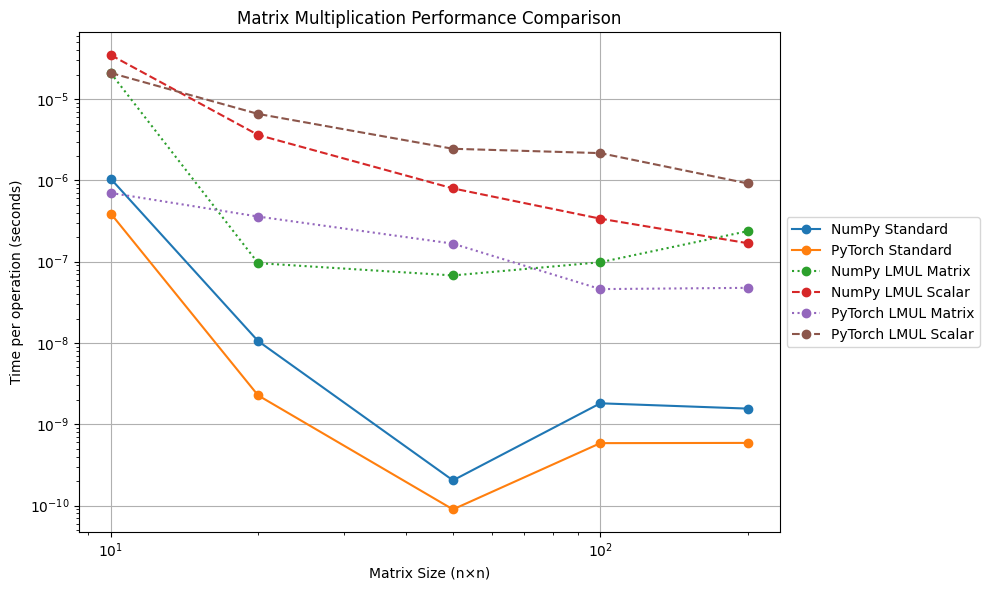

In [5]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

plt.plot(matrix_sizes, np_op_times, label='NumPy Standard', marker='o')
if TORCH_AVAILABLE:
    plt.plot(matrix_sizes, pytorch_standard_op_times, label='PyTorch Standard', marker='o')
plt.plot(matrix_sizes, numpy_lmul_op_times, label='NumPy LMUL Matrix', marker='o', linestyle=':')
plt.plot(matrix_sizes, numpy_lmul_scalar_op_times, label='NumPy LMUL Scalar', marker='o', linestyle='--')
if TORCH_AVAILABLE:
    plt.plot(matrix_sizes, pytorch_lmul_op_times, label='PyTorch LMUL Matrix', marker='o', linestyle=':')
    plt.plot(matrix_sizes, pytorch_lmul_scalar_op_times, label='PyTorch LMUL Scalar', marker='o', linestyle='--')

plt.xlabel('Matrix Size (n×n)')
plt.ylabel('Time per operation (seconds)')
plt.title('Matrix Multiplication Performance Comparison')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
